In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
import pylab
import scipy
import sklearn
import time
import seaborn as sns
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [233]:
pd.set_option("display.max_rows", 250000)
pd.set_option("display.max_columns", 250000)

In [4]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

Itgam, Ly6g, Ptprc, Cd3e, Ly76, Kit, Ly6a, Cd48, Slamf1

In [5]:
import re
df1_1 = df1[~df1.index.str.contains('biol_replicate')]
df1_1 = df1_1.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])
df1_1 = df1_1.drop(['Itgam', 'Ptprc', 'Kit', 'Ly6a', 'Cd48', 'Slamf1'], axis = 1)

In [6]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, young_LT_HSC_2 to old_MPP_168
Columns: 8416 entries, Npl to Sft2d1
dtypes: object(8416)
memory usage: 67.9+ MB


In [7]:
df1_1.index = df1_1.index.str.replace(r'[^a-zA-Z]', '')

print((df1_1.columns).shape)
print(np.unique(df1_1.columns).shape)

(8416,)
(8351,)


In [8]:
df1_1dup = df1_1[df1_1.loc[:,df1_1.columns.duplicated()].columns]


In [9]:
dupcols = np.unique(df1_1dup.columns)
dupcols

array(['Abcg2', 'Arih1', 'Atf7ip', 'Atrip', 'Brwd1', 'Cbx1', 'Ccnd3',
       'Cdk6', 'Celf1', 'Commd1', 'Csnk1a1', 'Ctse', 'Dnajb6', 'Eci2',
       'Eif1ax', 'Fgd4', 'Fus', 'G3bp1', 'Glod4', 'Gm10598', 'Gm13215',
       'Hjurp', 'Ikbkb', 'Ing4', 'Itga4', 'Itga6', 'Kansl2', 'Lcor',
       'Lrrc29', 'Luc7l2', 'Mafg', 'Mecom', 'Mob1a', 'Mtcp1', 'Nagk',
       'Ndufa3', 'Pafah1b1', 'Patz1', 'Pcif1', 'Pik3ip1', 'Psme4', 'Pten',
       'Ramp2', 'Rpl24', 'Rspry1', 'Satb1', 'Smarcc2', 'Srcap', 'Srsf10',
       'Sugp2', 'Taf9', 'Tex261', 'Tmem167b', 'Tmem181b-ps', 'Trappc9',
       'Trim30b', 'U2af1l4', 'Utp23', 'Wwp2', 'Zbtb20', 'Zfp708',
       'Zfp869', 'Zgpat'], dtype=object)

In [10]:
df1_1dupgroup = df1_1dup.groupby(df1_1dup.columns, axis=1).sum()

In [11]:
df1_1dupmean = pd.DataFrame()
for x in dupcols:
    df1_1dupmean[x] = df1_1dupgroup[x]/df1_1dup.columns.tolist().count(x)


In [12]:
# cols = []
# n = 1
# for x in df2dup.columns:
#     if x in cols:
#         cols.append(x+'.'+str(n))
#         n += 1
#     else:
#         cols.append(x)
#         n = 1


In [13]:
dfnodup = df1_1.loc[:,~df1_1.columns.duplicated()].drop(dupcols, axis = 1)

df2 = pd.concat([dfnodup, df1_1dupmean], axis = 1)

df2= df2.round(2)
df2.shape

(1058, 8351)

In [14]:
genefracs = (df2==0).sum()/(df2==0).count()
passindex = genefracs[genefracs < 0.95]


In [15]:
zifa = df2[passindex.index]
zifa= np.round(zifa.astype(np.float64),4)
zifa = np.array(zifa)
zifa.shape

(1058, 8240)

In [16]:
from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [17]:
start_time = time.time()
Z, model_params = block_ZIFA.fitModel(zifa, 10)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 16
Running block zero-inflated factor analysis with N = 1058, D = 8240, K = 10, n_blocks = 16
Block sizes [515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515]
Param change below threshold 1.000e-02 after 13 iterations
--- 1251.6910688877106 seconds ---


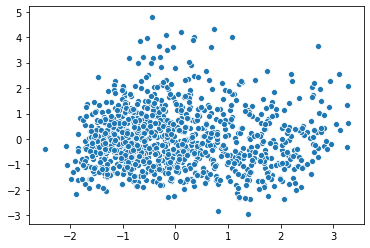

In [104]:
dfz = pd.DataFrame(Z, index = df2.index)
pcaz = PCA(n_components=3, random_state = 42)

zcomps = pcaz.fit_transform(dfz)
sns.scatterplot(zcomps[:,0], zcomps[:,1])
plt.show()

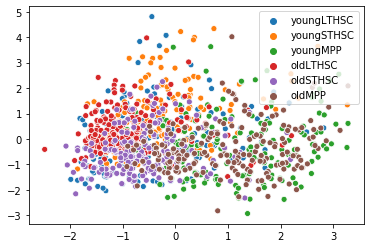

In [105]:
sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = dfz.index)
plt.show()

In [207]:
encoded = {'oldLTHSC':0, 'oldMPP':1, 'oldSTHSC':2, 'youngLTHSC':3, 'youngMPP':4, 'youngSTHSC':5}
cells = ['oldLTHSC' ,'oldMPP', 'oldSTHSC', 'youngLTHSC' ,'youngMPP' ,'youngSTHSC']
cell_types = [encoded.get(x, x) for x in dfz.index]
colormap = ['r', 'b', 'g', 'y', 'c', 'm']
cell_colors = [colormap[x] for x in cell_types]
dfpca = pd.DataFrame(zcomps, index = dfz.index)
dfpca
fig = px.scatter_3d(dfpca, zcomps[:,0], zcomps[:,1],zcomps[:,2], dfpca.index)
fig.update_traces(marker=dict(opacity =1, size=4,
                              line=dict(width= .1)))

fig.show()

In [78]:
np.cov(dfz)

array([[ 0.14043607,  0.14160263,  0.10634272, ..., -0.08388564,
        -0.09386797, -0.16723983],
       [ 0.14160263,  0.33916414,  0.22557225, ..., -0.29977444,
        -0.21575118, -0.45080038],
       [ 0.10634272,  0.22557225,  0.35283639, ..., -0.132259  ,
        -0.07406903, -0.35222496],
       ...,
       [-0.08388564, -0.29977444, -0.132259  , ...,  0.37432332,
         0.27351119,  0.41005679],
       [-0.09386797, -0.21575118, -0.07406903, ...,  0.27351119,
         0.42697508,  0.40940323],
       [-0.16723983, -0.45080038, -0.35222496, ...,  0.41005679,
         0.40940323,  0.70950523]])

Text(0.5, 1.0, 'ZIFA-UMAP (10 dim): genes with fewer than 95% zeros')

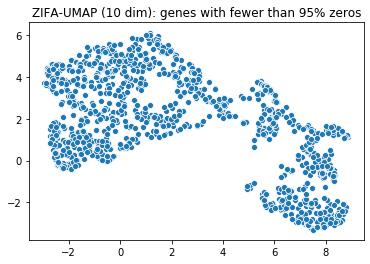

In [227]:
zumap = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz)
fig = sns.scatterplot(zumap[:,0], zumap[:,1])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 95% zeros')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

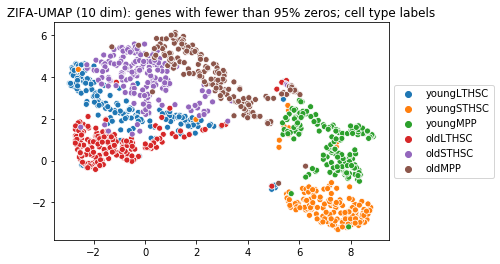

In [228]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = dfz.index)
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 95% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [193]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfz)
cluster = gmm.fit_predict(dfz)


In [194]:
dfz

0         1         2         3         4         5  \
youngLTHSC -0.444082  0.240140  0.195948  0.122692 -0.034564  0.322716   
youngLTHSC -1.275073  0.415516  0.237113  0.812672 -0.258834  0.477878   
youngLTHSC -1.362070 -1.027239 -0.101630 -0.075150 -0.944895  0.005346   
youngLTHSC  0.216852 -0.874159  0.249274  0.838159 -1.101343  0.515256   
youngLTHSC  0.864724 -0.320265  0.730423 -0.112532 -0.666707  1.173996   
youngLTHSC  0.001818 -0.686831  0.870206 -0.363698 -0.899917  1.396484   
youngLTHSC -1.573912 -0.350339 -0.572977  0.429243 -0.048157  0.162716   
youngLTHSC -1.250636 -0.815365  0.679286  0.030066 -0.776113 -0.475541   
youngLTHSC  0.034665  0.658582  0.748428  0.566995 -1.019943 -0.500752   
youngLTHSC  0.738094 -0.950445  1.354794 -0.175135 -1.780099 -0.340702   
youngLTHSC  2.834999 -0.393348  1.710148  1.143994 -0.449487  1.000848   
youngLTHSC -0.581356  0.266919  0.706132  0.626157 -0.921108 -0.427891   
youngLTHSC  0.295890  1.643812 -0.031379  0.835226 -0.187554 -0.476208   
youngLTHSC -2.010801 -0.763240  0.234723  0.910259 -1.133279  0.049541   
youngLTHSC -0.750605  0.091714  0.304269  0.368692 -0.392073 -0.160406   
youngLTHSC  2.816122  0.290139  1.729627 -0.448995 -0.723661  0.433142   
youngLTHSC  0.204291  1.366358  0.560022  0.694088 -0.220859 -0.151803   
youngLTHSC  0.973382  1.614382  0.109927  0.723029  0.642665 -1.121941   
youngLTHSC -1.288895 -0.416124  0.205815  0.907002 -0.622639 -0.570285   
youngLTHSC -0.475608 -0.553797 -0.040898  2.819452  0.786938  0.561694   
youngLTHSC  1.515126  0.119901  1.212746 -0.171273 -0.294070  0.901884   
youngLTHSC  0.154552 -0.287581  1.194935 -0.256108 -0.612889 -1.121975   
youngLTHSC  0.149654  0.535551  1.097292  0.585458 -0.973876 -0.059500   
youngLTHSC  1.118786 -2.599046  1.609994  2.486336 -0.433563 -1.078122   
youngLTHSC  0.717814 -0.836185  1.188962 -0.367372 -1.321245  0.081571   
youngLTHSC  0.659804  0.822432  1.542535  0.079444 -0.598731 -0.795830   
youngLTHSC  1.123164 -1.247725  1.427232 -0.515394 -1.091592  0.416475   
youngLTHSC  1.246930 -0.325611  1.873448 -1.293691 -0.831911  0.433084   
youngLTHSC  0.062650 -0.604749  0.643247 -0.832086 -0.375429 -0.557326   
youngLTHSC -1.518702 -0.124033  0.307343  0.573277 -1.108547  0.049571   
youngLTHSC  1.974642 -0.504492  1.233091  0.764540 -0.768408  1.186409   
youngLTHSC  1.235923  0.073915  0.924529  3.532546  1.084014 -0.281987   
youngLTHSC  0.802377  0.282750  1.663791 -0.249639 -0.745805 -1.523745   
youngLTHSC -0.920249  0.589933  0.766124  1.209552 -0.293134 -0.176140   
youngLTHSC -0.471085 -1.849719  1.019106  0.495002 -0.512150 -0.200895   
youngLTHSC -0.150675 -0.078457  1.157480  0.264433 -0.702938 -1.247232   
youngLTHSC -0.960199  0.599162  0.129130  0.792711  0.452843 -0.065863   
youngLTHSC  1.230210 -1.537710  1.857650  0.221076 -1.366509 -0.508251   
youngLTHSC  2.054969  1.956484  0.918288  0.224369  0.680141 -1.564412   
youngLTHSC  0.799033  1.566349  0.818401  0.354218  0.347345 -0.979004   
youngLTHSC -0.708334 -0.313992  0.984173  0.393557 -1.184845 -0.407877   
youngLTHSC  1.235571  2.619696  1.000657  0.686874 -0.018220  0.447598   
youngLTHSC -0.945251  1.117432  0.229695  0.979524  0.323627  0.148189   
youngLTHSC  0.860271  1.350389  1.245543  0.437931 -0.164092 -0.870259   
youngLTHSC -0.516430  0.088747  0.511956  0.240990 -0.304183 -0.850485   
youngLTHSC -0.219110  0.462779  0.377551  0.306009  0.055187 -0.741152   
youngLTHSC  0.421650  0.491032  0.825094  0.007015 -0.322671 -1.017075   
youngLTHSC  0.255035  0.108795  0.682204 -0.564395 -0.174863 -0.680306   
youngLTHSC  0.410085  0.003328  0.646964  0.398245 -0.651164 -0.852451   
youngLTHSC  1.021241  1.105820  0.918175  0.226315  0.125399 -1.186781   
youngLTHSC -0.934306 -1.667353  0.875741 -0.326991 -0.902695 -0.927726   
youngLTHSC  0.080891  1.216985  0.563071  0.904990 -0.405745 -0.877280   
youngLTHSC  0.393389  1.717168  0.197348  1.299385  0.283602 -0.508386   
youngLTHSC  2.249867  3

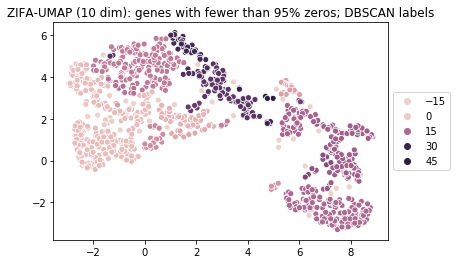

In [229]:
dbscan = DBSCAN(eps = .25, min_samples = 2)
dbscan.fit(zumap)
type(dbscan)
dbpred = dbscan.labels_
np.unique(dbpred)
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = dbpred)#, palette =['b', 'r', 'g', 'm', 'c', 'y', 'k', 'grey', 'w'])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 95% zeros; DBSCAN labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [234]:
pd.crosstab(dfz.index, dbpred)

col_0       -1    0    1    2    3    4    5    6    7    8    9    10   11  \
row_0                                                                         
oldLTHSC      2    2    0  146    2    2    6    3    0    1   14    2    2   
oldMPP        4    0    0    1    0    0    0   19    0    1    0    0    0   
oldSTHSC      7    1    0   24    5    0    0    3    0    0    0    0    1   
youngLTHSC    7    3    2  100   29    4    3    3    2    4    2    2    2   
youngMPP      3    0    0    0    0    0    0    0    0    0    0    0    0   
youngSTHSC    6    0    0    1    1    0    0    0    0    0    0    0    0   

col_0        12   13   14   15   16   17   18   19   20   21   22   23   24  \
row_0                                                                         
oldLTHSC      0    0    1    0    0    0    0    0    0    0    0    0    0   
oldMPP       29    0    0    0    0    0    0    0    0    0    0    0    0   
oldSTHSC    120    7    6    0    0    0    0    0    0    0    0    0    3   
youngLTHSC    2    1    1    0    0    0    0    0    0    0    0    0    0   
youngMPP      0    0    0    2   40  109    0    3    3    2    2    4    0   
youngSTHSC    0    0    0  144    5    2    4    0    0    0    0    0    0   

col_0        25   26   27   28   29   30   31   32  
row_0                                               
oldLTHSC      0    0    0    0    0    0    0    0  
oldMPP        0   73    0   17   35    4    2    3  
oldSTHSC      2    6    3    1    0    0    0    0  
youngLTHSC    0    0    0    0    0    0    0    0  
youngMPP      0    0    0    0    0    0    0    0  
youngSTHSC    0    0    0    0    0    0    0    0

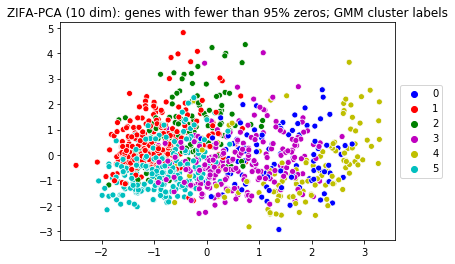

In [208]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = cluster,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (10 dim): genes with fewer than 95% zeros; GMM cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

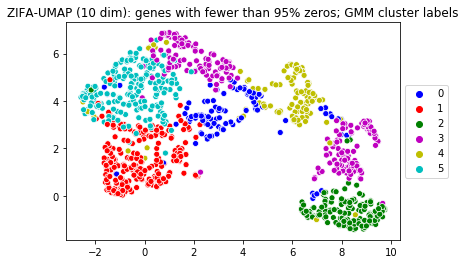

In [197]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = cluster,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 95% zeros; GMM cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [198]:
km = KMeans(n_clusters = 6, random_state=42)
kmdata = km.fit_transform(dfz)
kpred = km.fit_predict(dfz)

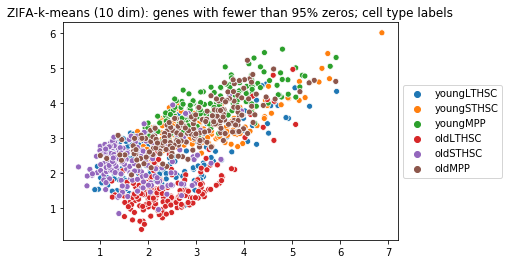

In [210]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:,1], hue = dfz.index)
fig.set_title('ZIFA-k-means (10 dim): genes with fewer than 95% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

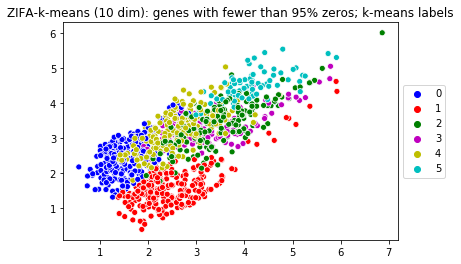

In [211]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:, 1], hue = kpred,palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-k-means (10 dim): genes with fewer than 95% zeros; k-means labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

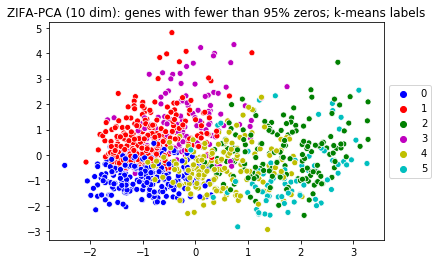

In [212]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (10 dim): genes with fewer than 95% zeros; k-means labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

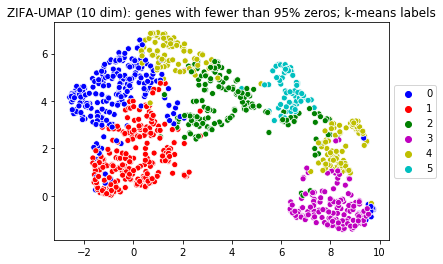

In [202]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 95% zeros; k-means labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

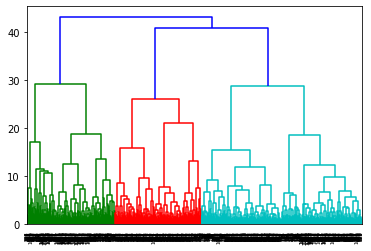

In [203]:
dendrogram(linkage(dfz, method = 'ward'))
plt.show()

In [159]:
dfcelltypes = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcelltypes['youngLTHSC'] = df2[df2.index == 'youngLTHSC'].mean()
dfcelltypes['youngSTHSC'] = df2[df2.index == 'youngSTHSC'].mean()
dfcelltypes['youngMPP'] = df2[df2.index == 'youngMPP'].mean()
dfcelltypes['oldLTHSC'] = df2[df2.index == 'oldLTHSC'].mean()
dfcelltypes['oldSTHSC'] = df2[df2.index == 'oldSTHSC'].mean()
dfcelltypes['oldMPP'] = df2[df2.index == 'oldMPP'].mean()


In [160]:
dfcellbroad = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcellbroad['HSC'] = df2[df2.index.str.contains('HSC')].mean()
dfcellbroad['MPP'] = df2[df2.index.str.contains('MPP')].mean()
dfcellbroad['HSC/MPP'] = dfcellbroad['HSC']/dfcellbroad['MPP']
dfcellbroad.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(25000)


All cell average  \
Efna1                                                       0.643544   
Epor                                                        0.195877   
A230065H16Rik                                               0.188853   
Entpd2                                                      0.118546   
uc012bnh.1                                                  0.012621   
Chst2                                                       0.390360   
Tenc1                                                       0.414738   
Sytl5                                                       0.261054   
Smtnl1                                                      0.344110   
Fkbp10                                                      0.207363   
Trim47                                                      0.618175   
Sdpr                                                        1.132630   
Prom2                                                       0.127064   
Gstm2                                                       0.393672   
Cldn5                                                       0.133280   
Nupr1                                                       2.090327   
Gpx3                                                        0.422264   
D630039A03Rik                                               0.693411   
Plxdc2                                                      0.888490   
Clip3                                                       0.347333   
Pde6h                                                       0.221191   
uc007cvp.1,uc007cvq.1                                       0.324404   
Snrpn                                                       0.428033   
Upp1                                                        0.927185   
Gm13986                                                     0.386996   
Ndn                                                         1.065439   
Tgm2                                                        2.373461   
Sult1a1                                                     1.656241   
Hid1                                                        0.731313   
Tgfb3                                                       0.188622   
Zfp612                                                      0.548159   
Eno2                                                        0.214290   
Hba-a2                                                      0.698456   
Mt2                                                         0.389157   
Tinagl1                                                     1.058981   
Reep2                                                       0.324417   
Ehd3                                                        0.907648   
Fam46c                                                      0.120244   
Fam110c                                                     0.711369   
Abcg3                                                       2.109270   
Clca1                                                       0.969792   
Vwf                                                         1.211336   
Clec1a                                                      1.491799   
Hbb-b1                                                      0.696732   
Kazald1                                                     0.335396   
Ocln                                                        0.451780   
Rprm                                                        0.116883   
Npdc1                                                       1.094193   
Mmrn1                                                       4.407780   
Clu                                                         1.038810   
Wfdc2                                                       0.509162   
Grb10                                                       2.193117   
Rhd                                                         0.059553   
Hgfac                                                       0.722850   
Gimap4                                                      0.461725   
Abcb1a              